In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [529]:
dset_ord = ['Ballroom', 'GTZAN', 'FMA_SUB', 'IRMAS_SUB', 'EmoAro', 'EmoVal', 'ThisIsMyJam']
single_tasks = ['self', 'year', 'bpm', 'pref', 'tag', 'lyrics', 'cdr_tag', 'artist']

In [549]:
# load result data sheets & load on dataframe
D = pd.read_csv('../data/results/Experiment Result - result_share[new].csv')
# D = D.drop(['ThisIsMyJam'], axis=1).rename(index=str, columns={u'ThisIsMyJam2': u"ThisIsMyJam"})
D_ind = pd.read_csv('../data/results/Experiment Result - result_ind[new].csv')
D_des = pd.read_csv('../data/results/Experiment Result - fract_fact_design_train.csv', index_col=0).dropna()

# do simple pre-processing (average over the 5 test runs)
D_des.index.name = 'train_run'
d = D.groupby(['train_run']).mean()[dset_ord]
d.loc['choi_paper',:] = [None, 89.8, None, None, 0.6560, 0.4620, None]
di = D_ind.groupby(['train_run']).mean()[dset_ord]
d['branch_at'] = D_des['branch_point']
di['branch_at'] = D_des['branch_point']
di.loc['A@null', 'branch_at'] = 'null'

# Single Task Representation Benchmark

In [551]:
ss = D[D['train_run'].isin(['S{:d}'.format(i) for i in range(8)])]
for i, dset in enumerate(single_tasks):
    ss.loc[ss['train_run']=='S{:d}'.format(i), 'train_run'] = dset
single_task_res_raw = ss.set_index('train_run')[dset_ord]
single_task_res_raw.index.rename('index', inplace=True)

# single_task_res_raw = d.filter(like='S',axis=0).loc[:, d.columns != 'branch_at']
# single_task_res_raw.index = single_tasks

single_task_res_raw.reset_index(level=0, inplace=True)
single_task_res = pd.melt(single_task_res_raw, id_vars='index', var_name='Dataset', value_name='Performance')

In [552]:
single_task_res.loc[single_task_res['index']=='pref', 'index'] = 'taste'

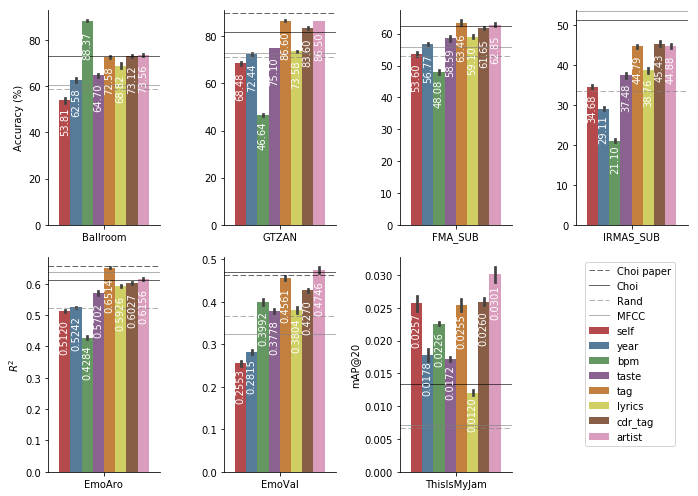

In [558]:
g = sns.FacetGrid(single_task_res, col="Dataset", col_wrap=4, size=3.5, aspect=0.7, sharey=False, sharex=False)
g = g.map(sns.barplot, "Dataset", 'Performance', 'index', ci="sd",
          palette=sns.color_palette("Set1", n_colors=8, desat=.7))

axes = g.axes

axes[0].set_ylabel('Accuracy (%)')
axes[4].set_ylabel('$R^2$')
axes[-1].set_ylabel('mAP@20')

ls = {'choi_paper':'--', 'choi_tune':"-",'rand_tune':"--", 'mfcc_tune':"-"}
lbl = {'choi_paper':'Choi paper', 'choi_tune':'Choi', 'rand_tune':'Rand', 'mfcc_tune':'MFCC'}
c = {'choi_paper':'k', 'choi_tune':"k",'rand_tune':"gray", 'mfcc_tune':"gray"}
# ls = {'choi_paper':'--', 'choi_tune':"-",'rand_tune':"--", 'mfcc_tune':"-"}
# c = {'choi_paper':'k', 'choi_tune':"k",'rand_tune':"gray", 'mfcc_tune':"gray"}
# lb = dict(map(lambda x: (x, x.split('_')[0].upper()), ['choi_paper', 'choi_tune','rand_tune','mfcc_tune']))
xlb = {'Ballroom':'Ballroom',
       'GTZAN':'GTZAN',
       'FMA_SUB':'FMA',
       'IRMAS_SUB':'IRMAS',
       'EmoAro':'EmoAro',
       'EmoVal':'EmoVal',
       'ThisIsMyJam':'ThisIsMyJam'}

# display baselines and top ranker's performance in number
for i, dset in enumerate(['Ballroom', 'GTZAN', 'FMA_SUB', 'IRMAS_SUB', 'EmoAro', 'EmoVal', 'ThisIsMyJam']):
    axes[i].set_title('')
    axes[i].set_xlabel('')
    # put best ranker's performance
    # -- find the best guy
    for p in axes[i].patches:
        height = p.get_height()
        if dset in {'Ballroom', 'GTZAN'}:
            offset = 14
            tmp = '{:1.2f}'
        elif dset in {'FMA_SUB', 'IRMAS_SUB'}:
            offset = 10
            tmp = '{:1.2f}'
        elif dset in {'EmoVal', 'EmoAro'}:
            offset = 0.08
            tmp = '{:1.4f}'
        elif dset in {'ThisIsMyJam'}:
            offset = 0.002
            tmp = '{:1.4f}'
        axes[i].text(p.get_x()+p.get_width()/2.,
                     height - height * 0.05,
                     tmp.format(height),
                     ha="center",va='top', color='white', rotation=90)

    # draw baselines
    for baseline in ['choi_paper', 'choi_tune', 'rand_tune', 'mfcc_tune']:
        val = d.loc[baseline][dset]
        axes[i].axhline(val, linestyle=ls[baseline], color=c[baseline], label=lbl[baseline], alpha=0.6, lw=1)

plt.legend(bbox_to_anchor=(2.5, 1))
plt.tight_layout()
g.savefig("single_performance.pdf")

In [575]:
sns.color_palette("Set1", n_colors=8, desat=.7)

[(0.7752941176470588, 0.22078431372549023, 0.2262745098039215),
 (0.29156862745098033, 0.48647058823529415, 0.645686274509804),
 (0.35784313725490197, 0.6268627450980393, 0.3496078431372549),
 (0.5590196078431375, 0.3558823529411764, 0.5892156862745098),
 (0.85, 0.4986274509803922, 0.15000000000000002),
 (0.8799999999999998, 0.8799999999999999, 0.32000000000000006),
 (0.5768627450980393, 0.35725490196078435, 0.23098039215686272),
 (0.89921568627451, 0.5752941176470587, 0.7454901960784315)]

## Spearman Correlation for Rank Correlation between Task Category and Performance Rank

In [ ]:
# z = single_task_res_raw.set_index('index')
z = single_task_res_raw
z = z.drop('index',axis=1)
z['category'] = [0,1,2,3,3,4,4,5] # higher number means more 'expensive'
zr = z.rank(ascending=True)
# z.corr(method='spearman')
zmelt = pd.melt(zr.T)

In [16]:
# overall rank correlation between performance rank & task category
stats.spearmanr(zmelt.as_matrix()[:,0], zmelt.as_matrix()[:,1])

SpearmanrResult(correlation=0.72247696109280157, pvalue=1.5928769452517381e-11)

In [105]:
corr_task = {}
for dset in dset_ord:
    corr_res = stats.spearmanr(zr['category'], zr[dset])
    rho = corr_res.correlation
    p = corr_res.pvalue
    corr_task[dset] = {'rho':rho, 'p':p}
# corr_task['_Overall'] = {'rho':0.67426258532837291, 'p':1.0110920543643295e-09}
corr_task = pd.DataFrame(corr_task).T[['rho', 'p']]
corr_task

,rho,p
Ballroom,0.578355,0.133139
EmoAro,0.734993,0.037770
EmoVal,0.771140,0.025059
FMA_SUB,0.734993,0.037770
GTZAN,0.686797,0.059897
IRMAS_SUB,0.807288,0.015406
ThisIsMyJam,0.096393,0.820380


In [149]:
spearman_ci(corr_task['rho']['IRMAS_SUB'], 8)

(0.2379999092594613, 0.9637246664064412)

In [94]:
import math
def spearman_ci(r, n):
#     r = 0.684848
#     num = 10
    num = n
    stderr = 1.0 / math.sqrt(num - 3)
    delta = 1.96 * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return lower, upper
# print "lower %.6f upper %.6f" % (lower, upper)

# Comparison between $STL_{cct}$ and $MTL_{cct}$

In [351]:
# set target
# trg_dset = 'Ballroom'
# trg_dset = 'GTZAN'
trg_dset = 'EmoVal'
trg_dset = 'EmoAro'

# trg_case = 'MT-CR'
trg_case = 'MST-CR'

def draw_linreg_w_eq(df, ax, trg_dset, trg_case, color, branch_at=None, conf=True, line_shape='-', marker='o',
                     pred_conf=False, legend=False, scatter=True, x_offset=0, label='', *args, **kwargs):
    """"""
    # gen data
    if branch_at is None:
        cond = (df['Dataset']==trg_dset) & (df['Shared']==trg_case)
    else:
        cond = (df['Dataset']==trg_dset) & (df['Shared']==trg_case) & (df['branch_at'] == branch_at)
    aa = df[cond]
    cc = aa.dropna()
    x = cc['#task']
    y = cc['Performance']

    if scatter:
        s = ax.scatter(x+x_offset, y, marker=marker, c=color, s=35, alpha=0.5, label='_nolegend_')

    # fit lin model
    x2 = sm.add_constant(x)
    model = sm.OLS(y, x2)
    fitted = model.fit()
    x_pred = np.linspace(x.min()-0.5, x.max()+0.5, 50)
    x_pred2 = sm.add_constant(x_pred)
    y_pred = fitted.predict(x_pred2)
    
    # add equation for linear regressor on fitted line
    c, m = fitted.params
    r = fitted.rsquared
#     cm1lab="$y=%1.4fx+%1.2f$"%(m,c) + ' / ' + 'r^2=%1.2f'%(r)
#     cm1lab = "$y=%1.4fx+%1.2f$"%(m,c)
#     cm1lab = "$R^2$={:.2f} / p={:.2f}".format(fitted.rsquared, fitted.pvalues['#task'])
    cm1lab = label.format(fitted.rsquared)
    l, = ax.plot(x_pred, y_pred, line_shape, color=color, linewidth=1.5, label=cm1lab, alpha=1)
    
    if conf:
        # add confidence interval with 95%
        y_hat = fitted.predict(x2)
        y_err = y - y_hat
        mean_x = x2.mean()[1]
        n = len(x2)
        dof = n - fitted.df_model - 1
        t = stats.t.ppf(1-0.025, df=dof)
        s_err = np.sum(np.power(y_err, 2))
        A = s_err / (n-2)
        B = 1./n + (np.power((x_pred-mean_x),2)/
                    ((np.sum(np.power(x_pred,2)))-n*np.power(mean_x,2)))
        conf = t * np.sqrt(A * B)
        upper = y_pred + abs(conf)
        lower = y_pred - abs(conf)
        ax.fill_between(x_pred, lower, upper, color=color, alpha=0.05)

    if pred_conf:
        # add prediction interval with 95%
        sdev, lower2, upper2 = wls_prediction_std(fitted, exog=x_pred2, alpha=.05)
        ax.fill_between(x_pred, lower2, upper2, color=color, alpha=0.001)

    if legend:
        if scatter:
            ax.legend([(s,l)], [cm1lab], loc=2)
        else:
            ax.legend(loc=2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([x.min()-0.5, x.max()+0.5])
    
    return ax, fitted, ((s,l), cm1lab) # legend
      
# fig, ax = plt.subplots()
# ax, model = draw_linreg_w_eq(res, ax, trg_dset, trg_case = 'MST-CR', color='r',legend=False,x_offset=0.1)
# ax, model = draw_linreg_w_eq(res, ax, trg_dset, trg_case = 'MT-CR', color='b',legend=True,x_offset=-0.1)
# print('p', fitted.pvalues)
# print('w', fitted.params)

In [531]:
# do simple pre-processing (average over the 5 test runs)
d2 = d.copy()
di2 = di.copy()
d2['#task'] = D_des['n_task'].astype(int)
di2['#task'] = D_des['n_task'].astype(int)
di2.loc['A@null', '#task'] = 8

d_2 = d2.dropna().iloc[:82]
d_2_fc = d_2[d_2['branch_at']=='fc']
d_2_cct = d_2[d_2['branch_at']!='fc']
res = pd.concat([d_2_cct.assign(Shared='MT-CR'),
                 d_2_fc.assign(Shared='MT-SR'),
                 di2.assign(Shared='MST-CR')])
res = pd.melt(res, id_vars=['branch_at', 'Shared', '#task'], var_name=['Dataset'], value_name='Performance')
# res.loc[~res['Shared'],['branch_at']] = 'STL_cct'
# res = res[res['branch_at'] != 'fc'].dropna()
res = res.dropna()
res['#task'] = res['#task'].astype(int)

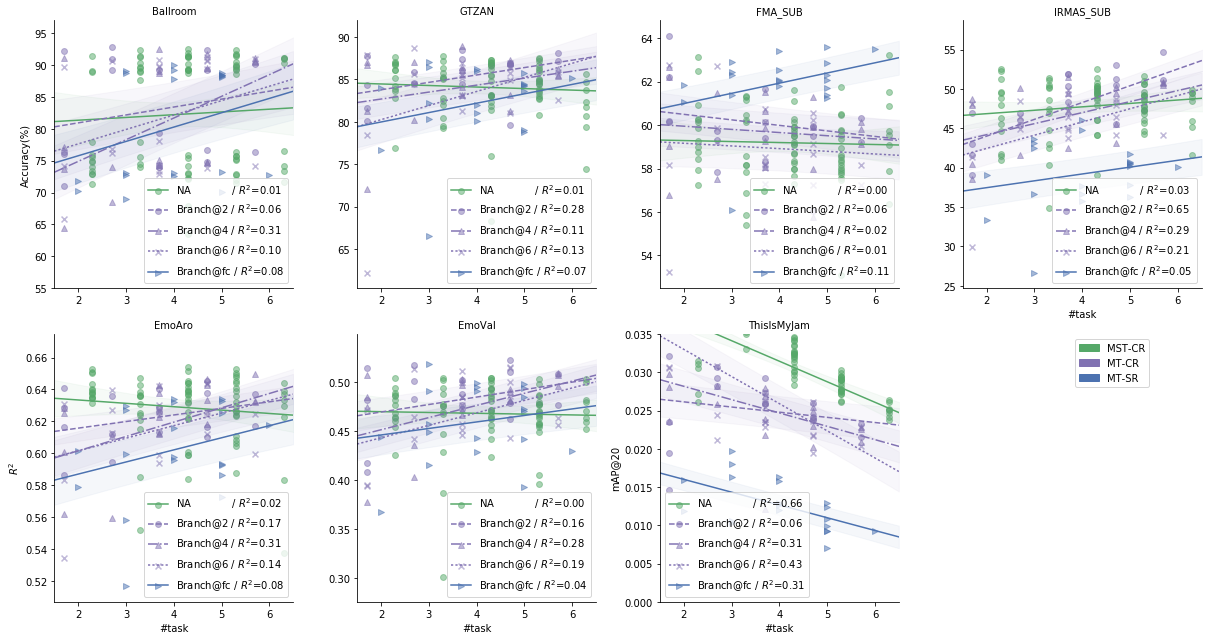

In [532]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(17,9))
axes[-1,-1].axis('off')
colors = [sns.color_palette("deep", 10)[i] for i in [1,3,0]]
models = {}
# patches for additional legends
mst_cr_patch = mpatches.Patch(color=colors[0], label='MST-CR')
mt_cr_patch = mpatches.Patch(color=colors[1], label='MT-CR')
mt_sr_patch = mpatches.Patch(color=colors[2], label='MT-SR')

for j, dset in enumerate(dset_ord):
    models[dset] = {}
    ax = axes.flatten()[j]
    legends = []
    legends_label = []
    for lgd, c, trg_case in zip([False, True, False], colors, ['MST-CR', 'MT-CR', 'MT-SR']):
        if trg_case == 'MT-CR':            
            # for branches
            for line_sh, marker, branch_at in zip(['--', '-.', ':'], ['o', '^', 'x'], ['2', '4', '6']):
                lb = "Branch@{}".format(branch_at) + " / $R^2$={:.2f}"
                kwargs = {
                    'trg_case':trg_case, 'color':c, 'legend':lgd, 'label':lb,
                    'branch_at':branch_at, 'line_shape':line_sh, 'marker':marker
                }
                ax, models[dset][trg_case], lg = draw_linreg_w_eq(res, ax, dset, x_offset=-0.3, **kwargs)
                legends.append(lg[0])
                legends_label.append(lg[1])
        elif trg_case == 'MT-SR':
                lb = "Branch@fc" + " / $R^2$={:.2f}"
                kwargs = {
                    'trg_case':trg_case, 'color':c, 'legend':lgd, 'label':lb,
                    'branch_at':'fc', 'line_shape':'-', 'marker':'>'
                }
                ax, models[dset][trg_case], lg = draw_linreg_w_eq(res, ax, dset, x_offset=-0.0, **kwargs)
                legends.append(lg[0])
                legends_label.append(lg[1])
        else:
            lb = "NA             / $R^2$={:.2f}"
            kwargs = {
                'trg_case':trg_case, 'color':c, 'legend':lgd, 'label':lb,
                'branch_at':None, 'line_shape':'-', 'marker':'o'
            }
            ax, models[dset][trg_case], lg = draw_linreg_w_eq(res, ax, dset, x_offset=0.3, **kwargs)
            legends.append(lg[0])
            legends_label.append(lg[1])
    ax.legend(legends, legends_label, loc=0)
    ax.set_title('{}'.format(dset), fontsize= 10)
    
map(lambda ax: ax.set_xlabel('#task'), axes.flatten()[3:])
axes.flatten()[0].set_ylabel('Accuracy(%)')
axes.flatten()[4].set_ylabel('$R^2$')
axes.flatten()[-2].set_ylabel('mAP@20')

axes.flatten()[0].set_ylim([55,97])
axes.flatten()[-2].set_ylim([0,0.035])

plt.tight_layout()
plt.legend(handles=[mst_cr_patch, mt_cr_patch, mt_sr_patch],bbox_to_anchor=(.8, 1))
plt.savefig("performance_over_n_tasks.pdf")

# Get Overall Performance Chart

In [378]:
# do simple pre-processing
#  -- get required flags and process (branch_at, shared) --> (STL, MTL)
d3 = d.copy()
d_3 = d3.iloc[:84]
d_3_fc = d_3[d_3['branch_at']=='fc']
d_3_cct = d_3[d_3['branch_at']!='fc']
ds_3 = d3.iloc[84:84+8]  # single task performances

di3 = di.copy()
di_3_fc = di3[di3['branch_at']=='fc']
di_3_cct = di3[di3['branch_at']!='fc']

# res2 = pd.concat([d_3_fc.assign(Tasks='Multi', Fusion='Shared'),
#                   d_3_cct.assign(Tasks='Multi', Fusion='Concat'),
#                   di_3_cct.assign(Tasks='Multi-Single', Fusion='Concat'),
#                   ds_3.assign(Tasks='Single', branch_at='fc', Fusion='$\emptyset$')])
res2 = pd.concat([d_3_fc.assign(Fusion='MT-SR'),
                  d_3_cct.assign(Fusion='MT-CR'),
                  di_3_cct.assign(Fusion='MST-CR'),
                  ds_3.assign(branch_at='fc', Fusion='ST-R')])[dset_ord+['Fusion', 'branch_at']]
res2 = pd.melt(res2, id_vars=['Fusion','branch_at'], var_name=['Dataset'], value_name='Performance')

res3 = pd.concat([d_3_fc.assign(Fusion='MT-SR'),
                  d_3_cct.assign(Fusion='MT-CR'),
                  di_3_cct.assign(Fusion='MST-CR'),
                  ds_3.assign(branch_at='fc', Fusion='ST-R')])

res3_ = res3.rank(numeric_only=True, ascending=False).std(axis=1)
res3_ = res3_.rename('Std. Rank')
res3 = pd.concat([res3_, res3[['Fusion', 'branch_at']]], axis=1).dropna()

ST-R 0.25898931001
MT-SR 0.127470090823
MT-CR 0.0855076327178
MST-CR 0.0118093767507


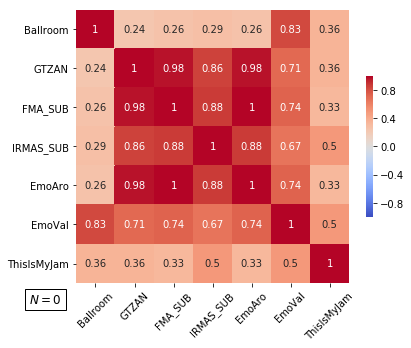

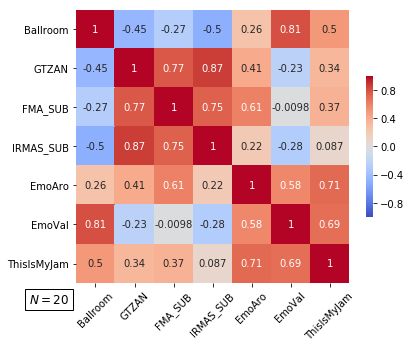

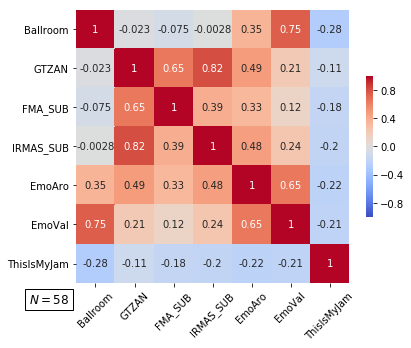

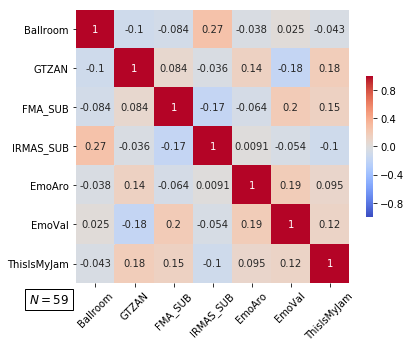

In [372]:
from collections import OrderedDict
data = OrderedDict([
#     'Overall_Shared':d_3,
    ('ST-R', ds_3),
    ('MT-SR', d_3_fc),
    ('MT-CR', d_3_cct),
    ('MST-CR', di_3_cct)
])

# fig, axs = plt.subplots(2, 2, figsize=(15,15))
for i, (k, d_) in enumerate(data.iteritems()):
    corr = d_.drop('branch_at', axis=1).corr('spearman')
    N = d_.dropna().shape[0]

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    print k, (corr * (1 - mask)).mean().mean()
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 5))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    g = sns.heatmap(corr, mask=None, vmax=1., vmin=-1., center=0, annot=True, cmap=plt.get_cmap('coolwarm'),
                square=True, cbar_kws={"shrink": .5}, cbar=True,
    )
    plt.xticks(rotation=45)
    t = g.axes.text(-1.2, 7.5, '$N={:d}$'.format(N), fontsize=12, family="serif")
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))
#     g.set_title(k)
#     print('\t\t\t{}'.format(k))
    plt.tight_layout()
    plt.savefig("rank_corr_{}.pdf".format(k))

In [ ]:
corr = d_.drop('branch_at', axis=1).corr('spearman')
N = d_.dropna().shape[0]

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
print k, (corr * mask).mean().mean()

In [373]:
for learning_task in single_tasks:
    task_runs = D_des[D_des[learning_task]==1].index
    corr = data['MT-CR'].drop('branch_at', axis=1).loc[task_runs].dropna().corr('spearman') 
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    print learning_task, (corr * (1 - mask)).sum().sum() / mask.sum()

self 0.188708013777
year 0.168236602621
bpm 0.20173442913
pref 0.1874325673
tag 0.0391105465373
lyrics 0.141915448516
cdr_tag 0.0962237078936
artist 0.0885022135127


('MST-CR', 2, 11)
('MT-CR', 2, 11)
('MST-CR', 3, 8)
('MT-CR', 3, 8)
('MST-CR', 4, 16)
('MT-CR', 4, 16)
('MST-CR', 5, 13)
('MT-CR', 5, 13)
('MST-CR', 6, 6)
('MT-CR', 6, 6)
('MST-CR', 7, 4)
('MT-CR', 7, 4)


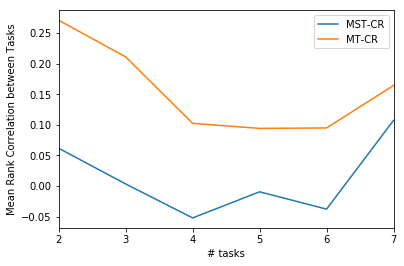

In [523]:
mean_corrs = {'MT-CR':{}, 'MST-CR':{}}

for ii in range(2, 8):
#     task_runs = D_des[D_des['n_task'] == ii].index
    for fusion, vec in mean_corrs.iteritems():
        if fusion == 'MST-CR':
            task_runs = D_des[D_des['n_task'] == ii].index.astype(int)
        else:
            task_runs = D_des[D_des['n_task'] == ii].index

        
        try:
            data_ = data[fusion].drop('branch_at', axis=1).loc[task_runs].dropna()
            print(fusion, ii, data_.shape[0])
            corr = data_.corr('spearman')
            mean_corrs[fusion][ii] = (corr * (1 - mask)).sum().sum() / mask.sum()
        except Exception as e:
            print e
            mean_corrs[fusion][ii] = None
            
pd.DataFrame(mean_corrs).plot()
plt.xlabel('# tasks')
plt.ylabel('Mean Rank Correlation between Tasks')


In [490]:
mean_corrs = {'MT-CR':{}, 'MST-CR':{}}

for fusion, vec in mean_corrs.iteritems():
    if fusion == 'MST-CR':
        task_runs = D_des[D_des['branch_point'] == ii].index.astype(int)
        corr = data[fusion].drop('branch_at', axis=1).dropna().corr('spearman')
        mean_corrs[fusion]['null'] = (corr * (1 - mask)).sum().sum() / mask.sum()
    else:
        for ii in ['2', '4', '6']:
            task_runs = D_des[D_des['branch_point'] == ii].index
            corr = data[fusion].drop('branch_at', axis=1).loc[task_runs].dropna().corr('spearman')
            mean_corrs[fusion][ii] = (corr * (1 - mask)).sum().sum() / mask.sum()

pd.DataFrame(mean_corrs)
# pd.DataFrame(mean_corrs).plot()
# plt.xlabel('branch@')
# plt.ylabel('Mean Rank Correlation between Tasks')

,MST-CR,MT-CR
2,NaN,0.107547
4,NaN,0.067732
6,NaN,0.139683
null,-0.009811,NaN


In [355]:
d3 = d.copy()
d_3 = d3.iloc[:84]
d_3_fc = d_3[d_3['branch_at']=='fc']
d_3_cct = d_3[d_3['branch_at']!='fc']
ds_3 = d3.iloc[84:84+8]  # single task performances

di3 = di.copy()
di_3_fc = di3[di3['branch_at']=='fc']
di_3_cct = di3[di3['branch_at']!='fc']


In [356]:
DD = pd.concat([d_3[d_3['branch_at']!='fc'].assign(Type='MT-CR'),
                d_3[d_3['branch_at']=='fc'].assign(Type='MT-SR'),
                d3.iloc[84:84+8].assign(Type='ST-R'),
                di3[di3['branch_at']!='fc'].assign(Type='MST-CR'),
                d3.loc[['choi_tune', 'mfcc_tune', 'rand_tune']].assign(Type='Baselines')])
DD2 = DD.copy()
DD2.loc[:,:7] = DD.rank(numeric_only=True, ascending=False)
DD2.index = DD2.index.astype(str)

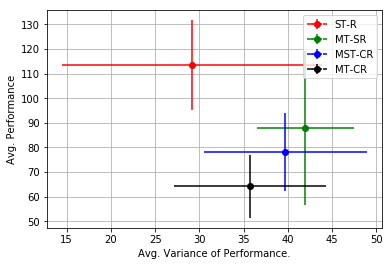

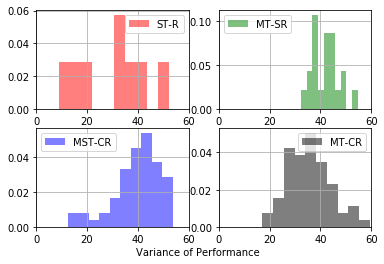

In [357]:
mean_rank = {}
mean_rank_corr = {}
median_std_rank = {}
inconsistency = {}

cs = ['r', 'g', 'b', 'k']

fig2, axs2 = plt.subplots(1,1)
fig, axs = plt.subplots(2,2)
for i, typ in enumerate(['ST-R', 'MT-SR', 'MST-CR', 'MT-CR']):
    # draw the histogram
    DD2[DD2['Type']==typ].drop(['branch_at','Type'],axis=1)\
    .dropna().std(axis=1)\
    .hist(alpha=0.5, label=typ, normed=1, ax=axs.flatten()[i], color=cs[i])
    
    # get inconsistency
    std_perf_over_tasks = DD2[DD2['Type']==typ].drop(['branch_at','Type'],axis=1).dropna().std(axis=1)
    inconsistency[typ] = std_perf_over_tasks.mean()
    
    # get avg. perf
    avg_rank_over_tasks = DD2[DD2['Type']==typ].mean()
    mean_rank[typ] = DD2[DD2['Type']==typ].mean(axis=0).mean()
  
    # get avg. rank corr. (another inconsistency)
    cc = DD[DD['Type']==typ].corr('spearman')
    cc.values[np.tril_indices_from(cc)] = np.nan
    mean_rank_corr[typ] = cc.unstack()
    
    axs2.errorbar(
        [std_perf_over_tasks.mean()],
        [avg_rank_over_tasks.mean()],
        yerr=avg_rank_over_tasks.std(),
        xerr=std_perf_over_tasks.std(),
        fmt='--o', ls='dashed', c=cs[i], label=typ
    )
#     axs2.errorbar(
#         [mean_rank_corr[typ].mean()],
#         [avg_rank_over_tasks.mean()],
#         yerr=avg_rank_over_tasks.std(),
#         xerr=mean_rank_corr[typ].std(),
#         fmt='--o', c=cs[i], label=typ
#     )
    
    axs.flatten()[i].legend()
    axs.flatten()[i].set_xlim([0,60])
fig.text(0.5, 0.04, 'Variance of Performance', ha='center', va='center')
    
axs2.legend(loc=0)
axs2.grid(True)
axs2.set_xlabel('Avg. Variance of Performance.')
# axs2.set_xlabel('Avg. Rank Correlation')
axs2.set_ylabel('Avg. Performance')

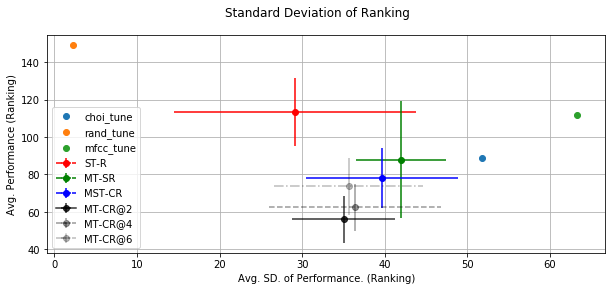

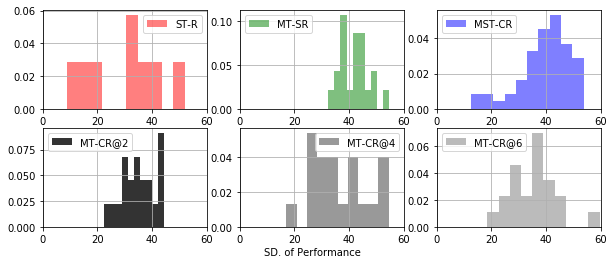

In [358]:
mean_rank = {}
mean_rank_corr = {}
median_std_rank = {}
inconsistency = {}

cs = ['r', 'g', 'b', 'k']

fig2, axs2 = plt.subplots(1,1, figsize=(10,4))
fig, axs = plt.subplots(2,3, figsize=(10, 4))
# axs2.scatter(mst_cr['avg_std'], mst_cr['avg_avg'], color='b', alpha=0.1)
# axs2.scatter(mt_cr['avg_std'], mt_cr['avg_avg'], color='g', alpha=0.1)
# for jj in range(2, 8):
#     plt.annotate(str(jj), (mst_cr.loc[jj,'avg_avg'], mst_cr.loc[jj,'avg_std']), color='b')
#     plt.annotate(str(jj), (mt_cr.loc[jj,'avg_avg'], mt_cr.loc[jj,'avg_std']), color='g')

for bsl in ['choi_tune', 'rand_tune', 'mfcc_tune']:
    axs2.scatter(
        DD2.loc[bsl].drop(['Type', 'branch_at']).std(),
        DD2.loc[bsl].drop(['Type', 'branch_at']).mean(),
        label=bsl
    )

for i, typ in enumerate(['ST-R', 'MT-SR', 'MST-CR', 'MT-CR']):
    if typ == 'MT-CR':
        for k, (st, branch) in enumerate(zip(['-', '--', '-.'], ['2', '4', '6'])):
            # draw the histogram
            filter_condition = (DD2['Type']==typ) & (DD2['branch_at']==branch)
            # find n_task
            DD2[filter_condition].drop(['branch_at','Type'],axis=1)\
            .dropna().std(axis=1)\
            .hist(alpha=1.6 / float(branch), label=typ + '@' + branch,
                  normed=1, ax=axs.flatten()[i+k], color=cs[i])

            # get inconsistency
            std_perf_over_tasks = DD2[filter_condition].drop(['branch_at','Type'],axis=1).dropna().std(axis=1)
            inconsistency[typ] = std_perf_over_tasks.mean()

            # get avg. perf
            avg_rank_over_tasks = DD2[filter_condition].mean()
            mean_rank[typ] = DD2[filter_condition].mean(axis=0).mean()

            # draw errorbar plot
            eb = axs2.errorbar(
                [std_perf_over_tasks.mean()],
                [avg_rank_over_tasks.mean()],
                yerr=avg_rank_over_tasks.std(),
                xerr=std_perf_over_tasks.std(),
                fmt='--o', ls=st, c=cs[i],
                label=typ + '@' + branch, alpha=1.6 / float(branch)
            )
            eb[-1][0].set_linestyle(st)
            axs.flatten()[i+k].legend()
            axs.flatten()[i+k].set_xlim([0,60])
    else:
        # draw the histogram
        DD2[DD2['Type']==typ].drop(['branch_at','Type'],axis=1)\
        .dropna().std(axis=1)\
        .hist(alpha=0.5, label=typ, normed=1, ax=axs.flatten()[i], color=cs[i])

        # get inconsistency
        std_perf_over_tasks = DD2[DD2['Type']==typ].drop(['branch_at','Type'],axis=1).dropna().std(axis=1)
        inconsistency[typ] = std_perf_over_tasks.mean()

        # get avg. perf
        avg_rank_over_tasks = DD2[DD2['Type']==typ].mean()
        mean_rank[typ] = DD2[DD2['Type']==typ].mean(axis=0).mean()

        # draw errorbar plot
        axs2.errorbar(
            [std_perf_over_tasks.mean()],
            [avg_rank_over_tasks.mean()],
            yerr=avg_rank_over_tasks.std(),
            xerr=std_perf_over_tasks.std(),
            fmt='--o', ls='dashed', c=cs[i], label=typ
        )
        axs.flatten()[i].legend()
        axs.flatten()[i].set_xlim([0,60])
fig.text(0.5, 0.04, 'SD. of Performance', ha='center', va='center')

axs2.legend(loc=3)
axs2.grid(True)
fig2.suptitle("Standard Deviation of Ranking")
axs2.set_xlabel('Avg. SD. of Performance. (Ranking)')
axs2.set_ylabel('Avg. Performance (Ranking)')

('MST-CR', 2, 11)
('MST-CR', 3, 8)
('MST-CR', 4, 16)
('MST-CR', 5, 13)
('MST-CR', 6, 7)
('MST-CR', 7, 3)
('MT-CR', 2, 11)
('MT-CR', 3, 8)
('MT-CR', 4, 16)
('MT-CR', 5, 13)
('MT-CR', 6, 7)
('MT-CR', 7, 3)


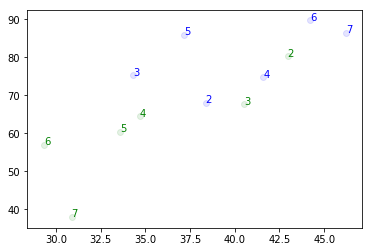

In [359]:
mean_rank = {}
mean_rank_corr = {}
median_std_rank = {}
inconsistency = {}
cs = ['r', 'g', 'b', 'k']

# draw the histogram
stat_n_task = {}
for fus in ['MST-CR', 'MT-CR']:
    stat_n_task[fus] = {}
    for n_t in range(2,8):
        stat_n_task[fus][n_t] = {}
        try:
            df_trg = DD2[DD2['Type']==fus].dropna().drop(['branch_at','Type'],axis=1)
            df_trg = df_trg.loc[D_des.loc[df_trg.index]['n_task'] == n_t]
            s = df_trg.std(axis=1).mean()
            v = df_trg.mean(axis=0).mean()
            stat_n_task[fus][n_t]['avg_std'] = s
            stat_n_task[fus][n_t]['avg_avg'] = v
            print(fus, n_t, df_trg.shape[0])
        except Exception as e:
            print e
            stat_n_task[fus][n_t]['avg_std'] = np.NaN
            stat_n_task[fus][n_t]['avg_avg'] = np.NaN

mst_cr = pd.DataFrame(stat_n_task['MST-CR']).T
mt_cr = pd.DataFrame(stat_n_task['MT-CR']).T

fig = plt.figure()
plt.scatter(mst_cr['avg_std'], mst_cr['avg_avg'], color='b', alpha=0.1)
plt.scatter(mt_cr['avg_std'], mt_cr['avg_avg'], color='g', alpha=0.1)
for jj in range(2, 8):
    plt.annotate(str(jj), (mst_cr.loc[jj,'avg_std'], mst_cr.loc[jj,'avg_avg']), color='b')
    plt.annotate(str(jj), (mt_cr.loc[jj,'avg_std'], mt_cr.loc[jj,'avg_avg']), color='g')

# # get inconsistency
# std_perf_over_tasks = DD2[DD2['Type']==typ].drop(['branch_at','Type'],axis=1).dropna().std(axis=1)
# inconsistency[typ] = std_perf_over_tasks.mean()

# # get avg. perf
# avg_rank_over_tasks = DD2[DD2['Type']==typ].mean()
# mean_rank[typ] = DD2[DD2['Type']==typ].mean(axis=0).mean()

# # draw errorbar plot
# axs2.errorbar(
#     [std_perf_over_tasks.mean()],
#     [avg_rank_over_tasks.mean()],
#     yerr=avg_rank_over_tasks.std(),
#     xerr=std_perf_over_tasks.std(),
#     fmt='--o', ls='dashed', c=cs[i], label=typ
# )
# axs.flatten()[i].legend()
# axs.flatten()[i].set_xlim([0,60])

In [393]:
from scipy import stats

def calc_rank_concordance(df):
    n, m = df.shape
    R_i = df.sum(axis=1)
    R_ = R_i.mean()
    S = ((R_i - R_)**2).sum()
    W = 12 * S / (m**2 * (n**3 - n))
    friedman = stats.friedmanchisquare(*[v for k, v in df.iteritems()])
    return W, friedman


for typ in ['MT-SR', 'MST-CR', 'MT-CR']:
    if typ == 'MT-CR':
        for branch in ['2', '4', '6']:
            cond = (DD['Type']==typ) & (DD['branch_at']==branch)
            df_target_data = DD[cond].rank().dropna().drop(['Type', 'branch_at'], axis=1)
            W, f = calc_rank_concordance(df_target_data)
            print "[{}@{}] - Kendall's W: {:.4f} - n: {:d} - m: {:d}"\
            .format(typ, branch, W, *df_target_data.shape)
            print f

    else:
        cond = DD['Type']==typ
        df_target_data = DD[cond].rank().dropna().drop(['Type', 'branch_at'], axis=1)
        W, f = calc_rank_concordance(df_target_data)
        print "[{}] - Kendall's W: {:.4f} - n: {:d} - m: {:d}".format(typ, W, *df_target_data.shape)
        print f


[MT-SR] - Kendall's W: 0.3889 - n: 21 - m: 7
FriedmanchisquareResult(statistic=1.8433098591548636, pvalue=0.9335304368106454)
[MST-CR] - Kendall's W: 0.1672 - n: 59 - m: 7
FriedmanchisquareResult(statistic=0.23787740164696225, pvalue=0.99974343733343218)
[MT-CR@2] - Kendall's W: 0.2844 - n: 20 - m: 7
FriedmanchisquareResult(statistic=1.7983348751156134, pvalue=0.93728008626138448)
[MT-CR@4] - Kendall's W: 0.2387 - n: 20 - m: 7
FriedmanchisquareResult(statistic=0.54189944134078039, pvalue=0.99729063376645821)
[MT-CR@6] - Kendall's W: 0.3153 - n: 21 - m: 7
FriedmanchisquareResult(statistic=0.88533333333331032, pvalue=0.98958813831735071)


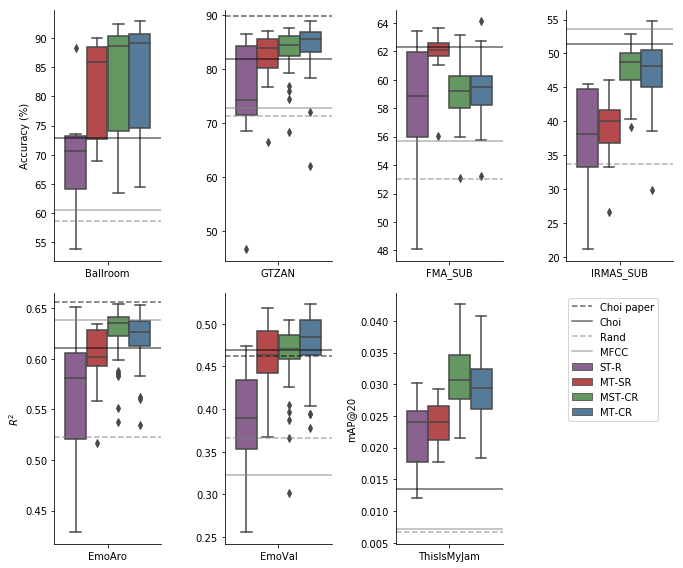

In [405]:
# draw
g = sns.FacetGrid(res2, col="Dataset", col_wrap=4, size=4, aspect=0.6, sharey=False, sharex=False)
g = g.map(sns.boxplot, "Dataset", 'Performance', "Fusion",
          hue_order=['ST-R', 'MT-SR', 'MST-CR', 'MT-CR'],
#           order=['$\emptyset$', 'Shared', 'CT'],
#           hue_order=['Single', 'Multi-Single', 'Multi'],
#           palette=sns.color_palette("Set1", n_colors=8, desat=.7)[3,0,2,1])
          palette=[sns.color_palette("Set1", n_colors=8, desat=.7)[r] for r in [3,0,2,1]])
axes = g.axes

axes[0].set_ylabel('Accuracy (%)')
# axes[2].set_ylabel('Accuracy (%)')
axes[4].set_ylabel('$R^2$')
axes[-1].set_ylabel('mAP@20')

ls = {'choi_paper':'--', 'choi_tune':"-",'rand_tune':"--", 'mfcc_tune':"-"}
lbl = {'choi_paper':'Choi paper', 'choi_tune':'Choi', 'rand_tune':'Rand', 'mfcc_tune':'MFCC'}
c = {'choi_paper':'k', 'choi_tune':"k",'rand_tune':"gray", 'mfcc_tune':"gray"}
# lb = dict(map(lambda x: (x, x.split('_')[0].upper()), ['choi_paper', 'choi_tune','rand_tune','mfcc_tune']))
xlb = {'Ballroom':'Ballroom',
       'GTZAN':'GTZAN',
       'FMA_SUB':'FMA',
       'IRMAS_SUB':'IRMAS',
       'EmoAro':'EmoAro',
       'EmoVal':'EmoVal',
       'ThisIsMyJam':'ThisIsMyJam'}

for i, dset in enumerate(['Ballroom', 'GTZAN', 'FMA_SUB', 'IRMAS_SUB', 'EmoAro', 'EmoVal', 'ThisIsMyJam']):
    axes[i].set_title('')
    axes[i].set_xlabel('')
    for baseline in ['choi_paper', 'choi_tune', 'rand_tune', 'mfcc_tune']:
        val = d.loc[baseline][dset]
        axes[i].axhline(val, linestyle=ls[baseline], color=c[baseline], label=lbl[baseline], alpha=0.6)

plt.legend(bbox_to_anchor=(2.5, 1))
plt.tight_layout()
g.savefig("overall_performance.pdf")

# Number of Task & Number model paramaters

In [574]:
from StringIO import StringIO

ntask_nparams = '''
fusion	1	2	3	4	5	6	7	8\n
MSS-CR		1146432	1719648	2292864	2866080	3439296	4012512	4585728\n
MS-CR@2		1145632	1718048	2290464	2862880	3435296	4007712	4580128\n
MS-CR@4		1122592	1671968	2221344	2770720	3320096	3869472	4418848\n
MS-CR@6		1012000	1450784	1889568	2328352	2767136	3205920	3644704\n
MS-SR@fc		586016	598816	611616	624416	637216	650016	662816\n
SS-R	573216							\n
'''

TESTDATA=StringIO(ntask_nparams)

df = pd.read_csv(TESTDATA, sep="\t", index_col=0)
df.to_csv('/home/ubuntu/workbench/MTLMusicRepresentation/data/complexity.csv')

In [572]:
compactness = pd.melt(df.reset_index(),
                      id_vars=['fusion'],
                      var_name=['number of learning sources'],
                      value_name='number of model parameters').dropna()

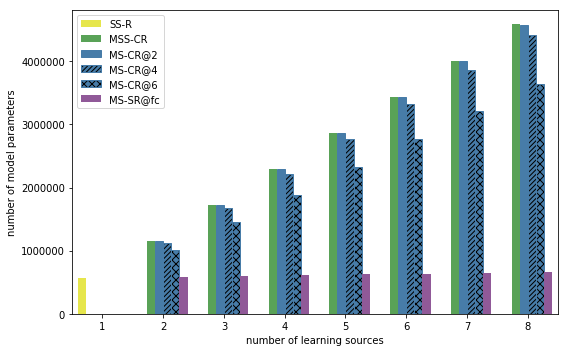

In [579]:
colors = [sns.color_palette("Set1", n_colors=8, desat=r[1])[r[0]]
          for r
          in [(5,1),(2,1),(1,1),(1,0.5),(1,0.1),(3,1)]]

fig, ax = plt.subplots(figsize=(8,5))

bars = sns.barplot(
    x='number of learning sources',
    y='number of model parameters',
    hue='fusion',
    data=compactness,
    palette=colors, ax=ax)
for bb in bars.patches:
    if bb.get_facecolor() == (0.2789215686274509, 0.48774509803921573, 0.6583333333333334, 1.0):
#         bb.set_hatch('\\\\')
        bb.set_color((0.2789215686274509, 0.48774509803921573, 0.6583333333333334, 1.0))
    elif bb.get_facecolor() == (0.3737745098039216, 0.47818627450980394, 0.5634803921568627, 1.0):
        bb.set_color((0.2789215686274509, 0.48774509803921573, 0.6583333333333334, 1.0))
        bb.set_hatch('/////')
    elif bb.get_facecolor() == (0.4496568627450981, 0.4705392156862745, 0.48759803921568623, 1.0):
        bb.set_color((0.2789215686274509, 0.48774509803921573, 0.6583333333333334, 1.0))
        bb.set_hatch('xxx')
        
plt.legend(loc=2)
plt.tight_layout()
plt.savefig("model_complexity_by_n_task.pdf")

In [566]:
bb.set_hatch?